# Kaggle competition Clean/Durty plates images

Dataset of differentiation pictures durty from clean palates.

<br> Data set is provided form [`Kaggle Clean/Dirty images`](https://www.kaggle.com/c/platesv2/data)

First, let's import requred dependensy

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os,glob, re
from PIL import Image
import pandas as pd
import random
import shutil
import cv2
from ipywidgets import widgets
from io import BytesIO

In [28]:
seed = 42
tf.random.set_seed(seed)

In [120]:
class_names = ["cleaned", "dirty"]
train_path = "/Users/sergeiakhmadulin/Documents/No_background/train/"
val_path = "/Users/sergeiakhmadulin/Documents/No_background/valid/"
test_path = "/Users/sergeiakhmadulin/Documents/No_background/test/"

In [82]:
orig_img = re.compile(r'^\d{4}\.jpg$')
augm_image = re.compile(r'augmented_image_\d{4}\.jpg_\d+')

Let's ivastigate how many images do we have for train and test

In [151]:
for class_name in class_names:
    full_path = train_path + class_name + "/"
    print(f"Files in train folder of class {class_name}: {len(list(filter(lambda x: x.endswith('.jpg'), os.listdir(full_path))))}")

Files in train folder of class cleaned: 20
Files in train folder of class dirty: 20


In [34]:
files = os.listdir(test_path)
files = list(filter(lambda x: x.endswith('.jpg'), files))
print(f"Files for labeling in test directory: {len(files)}")

Files for labeling in test directory: 744


So, we have very few original images for training models and a lot of images to lable. In this aproach I will use augmented technic, wich will help me generate many images by transforming original. 

In [103]:
def show_some_images(path, class_name, augmented = False, name_table = "Original"):
    full_path = train_path + class_name + "/"
    files = os.listdir(full_path)
    files = list(filter(lambda item: orig_img.match(item), files))
    if augmented:
        files = os.listdir(full_path)
        files = list(filter(lambda item: augm_image.match(item), files))

    files = [os.path.join(full_path, filename) for filename in files]  
    
    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    fig.suptitle(f'{name_table} images of class: {class_name}', fontsize=16)

    # Plot the first 4 images of each class
    for i, image in enumerate(files[:4]):
        img = tf.keras.utils.load_img(image)
        axes[i].imshow(img)
        axes[i].set_title(f'Example {class_name} {i}')
    
    plt.show()

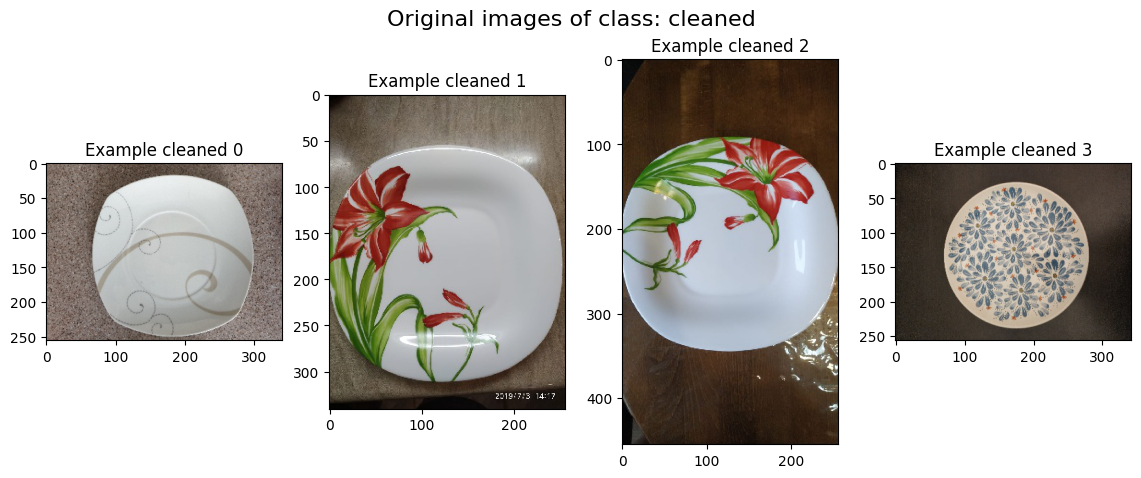

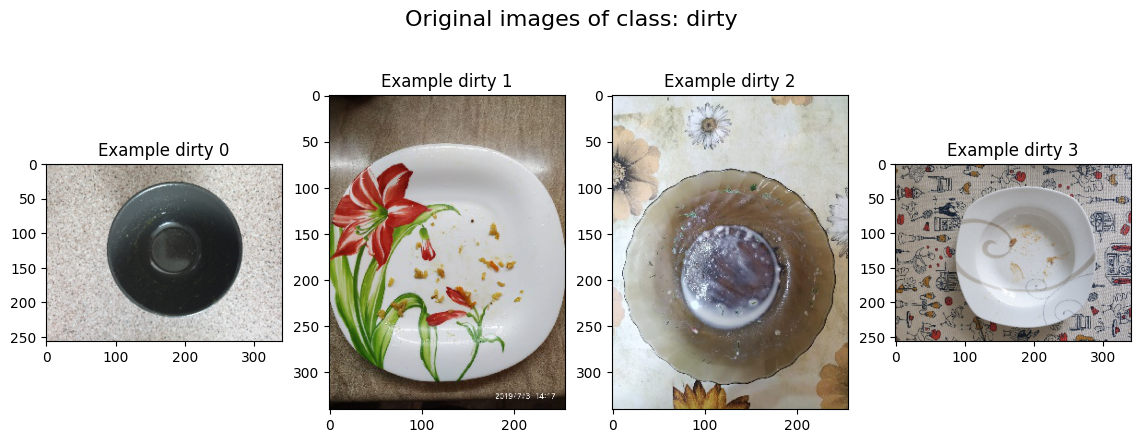

In [121]:
for i in range(2):
    show_some_images(train_path,class_names[i])

In [17]:
class MyRemoveBackground:
    """Remove images background.
    """
    
    def __init__(self):
        pass

    def __call__(self, in_img):
        
        # Convert PIL image to numpy array
        in_img = np.array(in_img)
        
        # Get the height and width from OpenCV image
        height, width = in_img.shape[:2]
        
        # Create a mask holder
        mask = np.zeros([height, width], np.uint8)

        # Grab Cut the object
        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        # Hard Coding the Rect The object must lie within this rect.
        rect = (15, 15, width-30, height-30)
        cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        out_img = in_img * mask[:, :, np.newaxis]

        # Get the background
        background = in_img - out_img

        # Change all pixels in the background that are not black to white
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        #Add the background and the image
        out_img = background + out_img

        return Image.fromarray(out_img)

In [18]:
def remove_background(image_roots):
    """Remove picture background.
       This function use MyRemoveBackground class.
    """
    remove_photo_background = MyRemoveBackground()

    print('Backgrounds removing started...')
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        print(f'{len(files)} pictures was found in {path}', end='')
        for i, file in enumerate(files):
            img_original = cv2.imread(path + file)
            img_cleaned = remove_photo_background(img_original)
            img_cleaned = np.array(img_cleaned)
            cv2.imwrite(path + file, img_cleaned)
            if i % 20 == 0:
                print('\n{:>3d}/{:>3d}'.format(i, len(files)), end='')
            print('.', end='')
        print()
    print('Backgrounds removing is complete.\n')

In [182]:
remove_background(image_roots=[os.path.join(train_path, 'cleaned/'),
                               os.path.join(train_path, 'dirty/')
#                                ,os.path.join(data_root, 'test/')
                              ])

Backgrounds removing started...
16 pictures was found in /Users/sergeiakhmadulin/Documents/No_background/train/cleaned/
  0/ 16................
16 pictures was found in /Users/sergeiakhmadulin/Documents/No_background/train/dirty/
  0/ 16................
Backgrounds removing is complete.



In [183]:
remove_background(image_roots=[os.path.join(val_path, 'cleaned/'),
                               os.path.join(val_path, 'dirty/')
#                                ,os.path.join(data_root, 'test/')
                              ])

Backgrounds removing started...
4 pictures was found in /Users/sergeiakhmadulin/Documents/No_background/valid/cleaned/
  0/  4....
4 pictures was found in /Users/sergeiakhmadulin/Documents/No_background/valid/dirty/
  0/  4....
Backgrounds removing is complete.



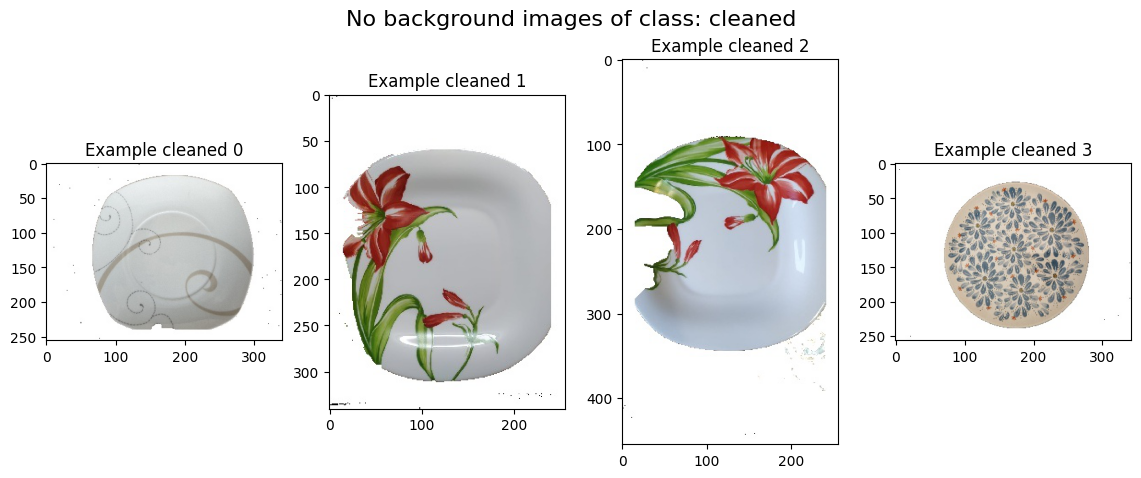

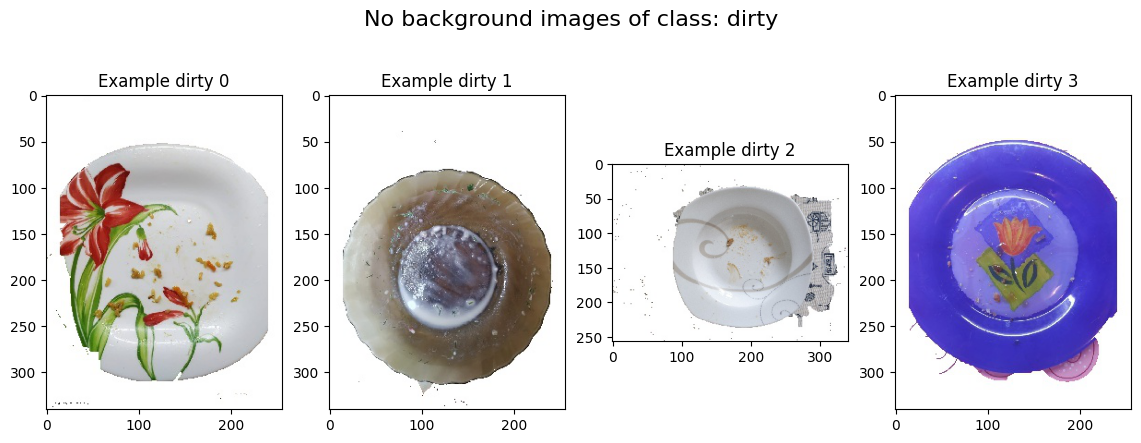

In [98]:
for i in range(2):
    show_some_images(train_path,class_names[i],name_table = "No background")

In [10]:
def move_random_files(source_folder, destination_folder, ratio_for_val):
    # Get all files in the source folder
    for class_name in class_names:
        full_path_source = source_folder + class_name + "/"
        full_destination_folder = destination_folder + class_name + "/"
        os.makedirs(full_destination_folder, exist_ok=True)
        files = os.listdir(full_path_source)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        whole_part = int(len(files) * ratio_for_val)
        # Randomly select the specified number of files
        if len(files) < whole_part:
            print(f"Not enough files to choose from. Available: {len(files)}")
            return
    
        selected_files = random.sample(files, whole_part)
        # Move each selected file to the destination folder
        for file_name in selected_files:
            shutil.move(os.path.join(full_path_source, file_name), os.path.join(full_destination_folder, file_name))
    print(f'Moved {len(selected_files)} files of each class to validation folder')

In [152]:
move_random_files(train_path, val_path, 0.2)

Moved 4 files of each class to validation folder


In [153]:
target_size = 224

In [154]:
def add_gaussian_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_image = image + noise
    return noisy_image


def preprocess_image(image):
    # Randomly choose a transformation
    transform_choice = np.random.choice(['none', 'noise', 'grayscale', 'brightness'])
    if transform_choice == 'noise':
        image = add_gaussian_noise(image)
    elif transform_choice == 'grayscale':
        image = tf.image.rgb_to_grayscale(image)
    elif transform_choice == 'brightness':
        image = tf.image.random_brightness(image, max_delta=0.2)

    return image

In [155]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,    
    rotation_range=90,
    vertical_flip=True,
    channel_shift_range = 0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [156]:
def generate_augm_data(datagen_function, folder, num_of_img, classes):
    pattern = re.compile(r'^\d{4}\.jpg$')
    print("Augmantation started...")
    for class_name in classes:
        full_path = folder + class_name + "/"
        original_images = []  # List to hold your original images
        files = os.listdir(full_path)
        files = list(filter(lambda x: pattern.match(x), files))
        for num_img, filename in enumerate(files):
            img = Image.open(os.path.join(full_path, filename))
            original_images.append(np.array(img))
        num_of_original_images = len(original_images)
        print(f"\nFound original images of class {class_name}: {num_of_original_images}")
        num_of_each_img = num_of_img//num_of_original_images
        num_of_new = 0
        for num_orig, img in enumerate(original_images):
            img = img.reshape((1,) + img.shape)  # Reshape for the generator
            current_count = 0
            for num_augm, batch in enumerate(datagen.flow(img, batch_size=1)):
                augmented_image = batch[0].astype(np.uint8)
                # Save or process your augmented images
                Image.fromarray(augmented_image).save(full_path + f'augmented_image_{files[num_orig]}_{num_augm}.jpg')
                current_count += 1
                num_of_new += 1
                if current_count >= num_of_each_img:
                    break
        print(f"Add new augmented images of class {class_name}: {num_of_new}")
    print("\nAugmentation finished.")

In [184]:
generate_augm_data(datagen, train_path, 30000, class_names)

Augmantation started...

Found original images of class cleaned: 16
Add new augmented images of class cleaned: 30000

Found original images of class dirty: 16
Add new augmented images of class dirty: 30000

Augmentation finished.


In [185]:
generate_augm_data(datagen, val_path, 700, class_names)

Augmantation started...

Found original images of class cleaned: 4
Add new augmented images of class cleaned: 700

Found original images of class dirty: 4
Add new augmented images of class dirty: 700

Augmentation finished.


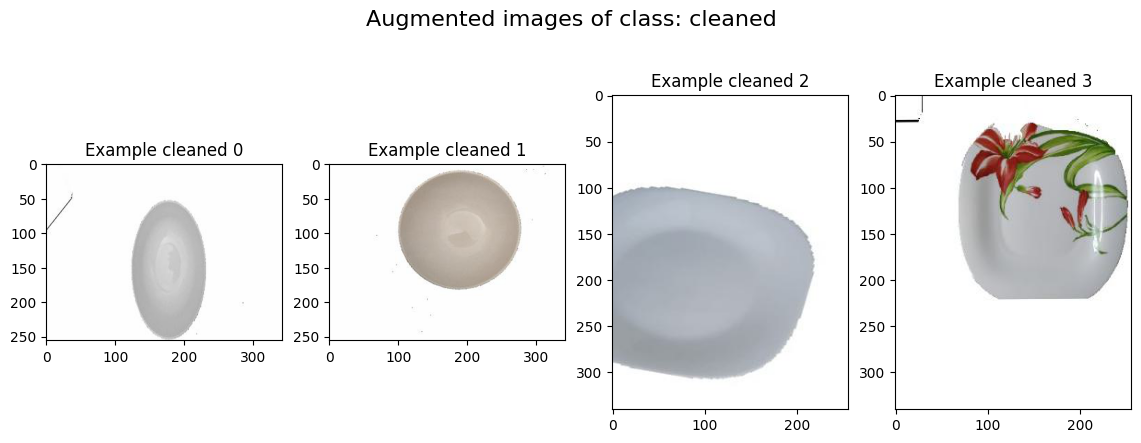

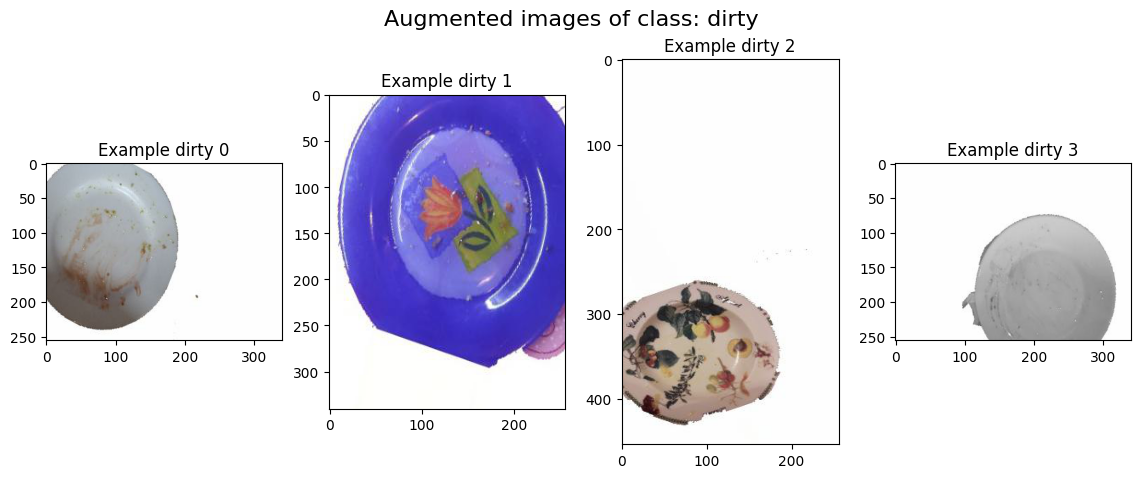

In [100]:
for i in range(2):
    show_some_images(train_path,class_names[i],augmented=True, name_table = "Augmented")

In [235]:
def train_val_datasets(train_path, val_path):
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=train_path,
        batch_size=10,
        image_size=(224, 224),
        shuffle=True, 
        seed = seed
        
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=val_path,
        batch_size=10,
        image_size=(224, 224),
        shuffle=True, 
        seed = seed
    ) 

    return training_dataset, validation_dataset

In [187]:
training_dataset, validation_dataset = train_val_datasets()

Found 60032 files belonging to 2 classes.
Found 1408 files belonging to 2 classes.


In [171]:
def normalize_image(image, label):
    # Normalize the image to [0, 1] by dividing by 255
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [172]:
training_dataset = training_dataset.map(normalize_image)
validation_dataset = validation_dataset.map(normalize_image)

In [4]:
def create_pre_trained_model():
    """Creates the pretrained EfficientNetB0 model

    Returns:
        tf.keras.Model: pre-trained model
    """
    
    pre_trained_model = tf.keras.applications.EfficientNetB0( 
        include_top=False, 
        input_shape=(224, 224, 3),
        weights='imagenet'
    ) 

    pre_trained_model.trainable = False

    return pre_trained_model

In [5]:
base_model = create_pre_trained_model()

In [6]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

In [206]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [207]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=5):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_accuracy = 0.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        
        if current_accuracy is None:
            return
        
        if current_accuracy - self.best_accuracy >= 0.03:
            self.best_accuracy = current_accuracy
            self.wait = 0
            print(f"New best accuracy: {self.best_accuracy:.4f}")
        else:
            self.wait += 1
            print(f"No improvement in epoch {epoch + 1}. Waiting {self.wait}/{self.patience}...")

        if self.wait >= self.patience:
            print("Early stopping triggered!")
            self.model.stop_training = True

        if logs['accuracy'] >= 0.99 and logs['val_accuracy'] >= 0.99:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")
            

In [208]:
checkpoint = ModelCheckpoint(
    'best_model_EfficientNetB0_base.keras',               # File name to save the model
    monitor='val_accuracy',         # Metric to monitor
    save_best_only=True,           # Save only the best model
    mode='max',                    # Mode (max for accuracy)
    verbose=1                      # Verbosity
)

In [209]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',       # Metric to monitor
    factor=0.2,               # Factor by which the learning rate will be reduced
    patience=2,               # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,              # Minimum learning rate
    verbose=1
)

In [210]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [211]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    verbose = 1,
    callbacks = [EarlyStoppingCallback(patience=3),checkpoint,reduce_lr],
)

Epoch 1/10
6003/6004 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9678 - loss: 0.0811New best accuracy: 0.7159

Epoch 1: val_accuracy improved from -inf to 0.71591, saving model to best_model_EfficientNetB0_base.keras
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 541s 90ms/step - accuracy: 0.9678 - loss: 0.0811 - val_accuracy: 0.7159 - val_loss: 2.9317 - learning_rate: 0.0010
Epoch 2/10
6003/6004 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9867 - loss: 0.0372No improvement in epoch 2. Waiting 1/3...

Epoch 2: val_accuracy did not improve from 0.71591
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 562s 94ms/step - accuracy: 0.9867 - loss: 0.0372 - val_accuracy: 0.6896 - val_loss: 4.5599 - learning_rate: 0.0010
Epoch 3/10
6003/6004 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9893 - loss: 0.0289No improvement in epoch 3. Waiting 2/3...

Epoch 3: val_accuracy did not improve from 0.71591

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 590s 98ms/step

In [216]:
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

# Compile and train the model again
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [217]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 5,153,117 (19.66 MB)

 Non-trainable params: 209,223 (817.28 KB)

In [218]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    verbose = 1,
    callbacks = [EarlyStoppingCallback(patience=3),checkpoint,reduce_lr],
)

Epoch 1/10
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9613 - loss: 0.2280New best accuracy: 0.7280

Epoch 1: val_accuracy improved from 0.71804 to 0.72798, saving model to best_model_EfficientNetB0_base.keras
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 1052s 174ms/step - accuracy: 0.9613 - loss: 0.2280 - val_accuracy: 0.7280 - val_loss: 3.2369 - learning_rate: 1.0000e-04
Epoch 2/10
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9916 - loss: 0.0230No improvement in epoch 2. Waiting 1/3...

Epoch 2: val_accuracy did not improve from 0.72798
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 1052s 175ms/step - accuracy: 0.9916 - loss: 0.0230 - val_accuracy: 0.7088 - val_loss: 2.7582 - learning_rate: 1.0000e-04
Epoch 3/10
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9934 - loss: 0.0171New best accuracy: 0.7599

Epoch 3: val_accuracy improved from 0.72798 to 0.75994, saving model to best_model_EfficientNetB0_base.keras
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 3523s 587ms/step - accuracy: 0.9

In [265]:
def make_predictions(model_name, image_path, target_size):
    remove_photo_background = MyRemoveBackground()
    
    results = []
    files = list(filter(lambda x: x.endswith('.jpg'), os.listdir(image_path)))
    for i, filename in tqdm(enumerate(files)):
        image_path_full = os.path.join(image_path, filename)

        
        img = load_img(image_path_full, target_size=(224,224))  # Resize to match model's input shape
        img_array = remove_photo_background(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
        # Predict the label
        prediction = model_name.predict(img_array, verbose=0)
        
        # Get the predicted class (for example, using argmax for multi-class classification)
        predicted_class = np.argmax(prediction, axis=1)
        results.append({'id': filename, 'label': predicted_class, 'probs': prediction[0][0]})
        
    results_df_test = pd.DataFrame(results)
    results_df_test["dirty"] = np.where(results_df_test["probs"]>=0.99,1,0)
    results_df_test["cleaned"] = np.where(results_df_test["probs"]<=0.01,1,0)
    
    results_df_test["label"] = np.where(results_df_test["probs"]>=0.5,"dirty","cleaned")
    
    return results_df_test

In [221]:
pred_test_first_attempt = make_predictions(model, test_path, target_size)

744it [02:50,  4.38it/s]


In [223]:
pred_test_first_attempt["dirty"].sum(), pred_test_first_attempt["cleaned"].sum()

(566, 106)

In [227]:
df_cleaned = pred_test_first_attempt[pred_test_first_attempt["cleaned"]==1]
id_cleaned = list(df_cleaned["id"])

df_dirty = pred_test_first_attempt[pred_test_first_attempt["dirty"]==1]
id_dirty = list(df_dirty["id"])

min_value = min(len(id_cleaned), len(id_dirty))

index_to_save = random.sample(range(min_value), min_value)

files_clean_to_stay = list(df_cleaned.iloc[index_to_save]["id"])
files_dirty_to_stay = list(df_dirty.iloc[index_to_save]["id"])

In [230]:
def make_new_dir_with_files_to_train(source_folder, destination_folder, 
                                     list_given_file_names_cleaned, list_given_file_names_dirty):

    # Get all files in the source folder
    for class_name in class_names:
        full_path_source = source_folder + "/"
        full_destination_folder = destination_folder + class_name + "/"
        os.makedirs(full_destination_folder, exist_ok=True)
        
        if class_name == "cleaned":
            matched_files_cleaned = [file for file in os.listdir(full_path_source) if file in list_given_file_names_cleaned]
            for file_name in matched_files_cleaned:
                shutil.copy(os.path.join(full_path_source, file_name), os.path.join(full_destination_folder, file_name))

        else:
            matched_files = [file for file in os.listdir(full_path_source) if file in list_given_file_names_dirty]
            for file_name in matched_files:
                shutil.copy(os.path.join(full_path_source, file_name), os.path.join(full_destination_folder, file_name))
            
    print(f'Copied files from test to new folder to train: {len(list_given_file_names_dirty)}')

In [27]:
path_new_files_train = "/Users/sergeiakhmadulin/Documents/new_files/train/"
path_new_files_val = "/Users/sergeiakhmadulin/Documents/new_files/valid/"

In [232]:
make_new_dir_with_files_to_train(test_path, path_new_files_train, 
                                     files_clean_to_stay, files_dirty_to_stay)

Copied files from test to new folder to train: 106


In [233]:
remove_background(image_roots=[os.path.join(path_new_files_train, 'cleaned/'),
                               os.path.join(path_new_files_train, 'dirty/')
                              ])

Backgrounds removing started...
106 pictures was found in /Users/sergeiakhmadulin/Documents/new_files/train/cleaned/
  0/106....................
 20/106....................
 40/106....................
 60/106....................
 80/106....................
100/106......
106 pictures was found in /Users/sergeiakhmadulin/Documents/new_files/train/dirty/
  0/106....................
 20/106....................
 40/106....................
 60/106....................
 80/106....................
100/106......
Backgrounds removing is complete.



In [234]:
move_random_files(path_new_files_train, path_new_files_val, 0.2)

Moved 21 files of each class to validation folder


In [237]:
generate_augm_data(datagen, path_new_files_train, 30000, class_names)

Augmantation started...

Found original images of class cleaned: 85
Add new augmented images of class cleaned: 29920

Found original images of class dirty: 85
Add new augmented images of class dirty: 29920

Augmentation finished.


In [238]:
generate_augm_data(datagen, path_new_files_val, 700, class_names)

Augmantation started...

Found original images of class cleaned: 21
Add new augmented images of class cleaned: 693

Found original images of class dirty: 21
Add new augmented images of class dirty: 693

Augmentation finished.


In [239]:
training_dataset, validation_dataset = train_val_datasets(path_new_files_train,path_new_files_val)

Found 60010 files belonging to 2 classes.
Found 1428 files belonging to 2 classes.


In [240]:
history_model_after_improvment = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    verbose = 1,
    callbacks = [EarlyStoppingCallback(patience=3),checkpoint,reduce_lr],
)

Epoch 1/10
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9836 - loss: 0.0568New best accuracy: 0.9671

Epoch 1: val_accuracy improved from 0.76420 to 0.96709, saving model to best_model_EfficientNetB0_base.keras
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 1036s 173ms/step - accuracy: 0.9836 - loss: 0.0568 - val_accuracy: 0.9671 - val_loss: 0.1256 - learning_rate: 2.0000e-05
Epoch 2/10
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9972 - loss: 0.0106No improvement in epoch 2. Waiting 1/3...

Epoch 2: val_accuracy did not improve from 0.96709
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 1040s 173ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9545 - val_loss: 0.2379 - learning_rate: 2.0000e-05
Epoch 3/10
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9982 - loss: 0.0050No improvement in epoch 3. Waiting 2/3...

Epoch 3: val_accuracy did not improve from 0.96709

Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
6001/6001 ━━━━━━━━━━━━━━━━━━

In [266]:
result_pred = make_predictions(model, test_path, target_size)

744it [04:54,  2.53it/s]


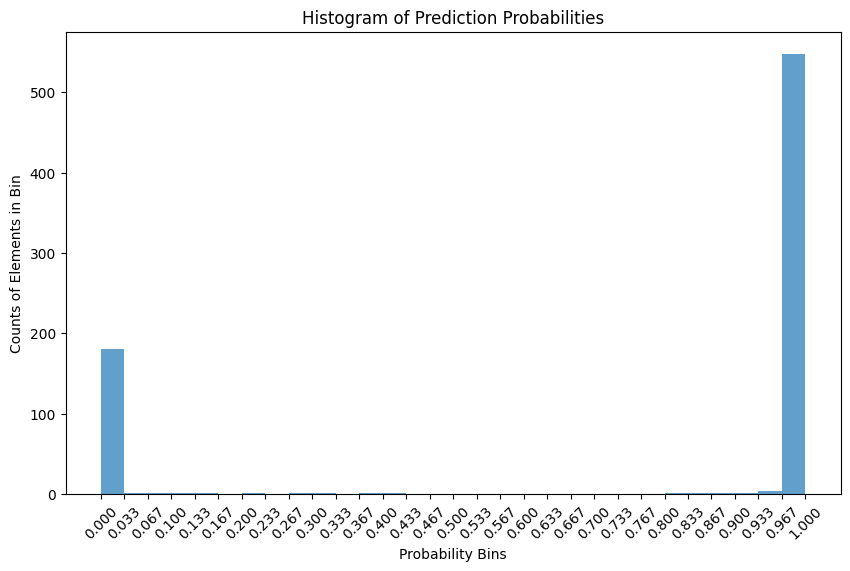

In [268]:
plt.figure(figsize=(10, 6))

# Create histogram
counts, bins, patches = plt.hist(result_pred["probs"], bins=np.linspace(0, 1, 20), alpha=0.7)

# Customize the x-ticks to show bin values
plt.xticks(bins, rotation=45)  # Rotate x-tick labels for better visibility

# Add labels and title
plt.title('Histogram of Prediction Probabilities')
plt.xlabel('Probability Bins')
plt.ylabel('Counts of Elements in Bin')

# Show the histogram
plt.show()

In [243]:
result_pred_to_csv = result_pred.iloc[:,:2]
result_pred_to_csv['id'] = result_pred_to_csv['id'].apply(lambda x: x.split('.')[0])

In [244]:
result_pred_to_csv

,id,label
0,0071,dirty
1,0717,dirty
2,0703,dirty
3,0065,dirty
4,0059,cleaned
...,...,...
739,0040,dirty
740,0726,cleaned
741,0732,dirty
742,0054,cleaned


In [245]:
result_pred_to_csv.to_csv('EfficientNetB0_added_img_test.csv',index=False)

Here is the screenshot of the submition for our predictions:

<div>
<img src="Kaggle_result_screen.webp" width="900"/>
</div>

In [7]:
model.load_weights('best_model_EfficientNetB0_base.keras')

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [110]:
from PIL import Image

In [ ]:


# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [122]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    img = load_img(file, target_size=(224,224))
    remove_photo_background = MyRemoveBackground()
    img_array = remove_photo_background(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    prediction = prediction[0][0]
    with out:

        prediction_index = 1 if prediction >= 0.5 else 0
        classes = ["cleaned", "dirty"]
        predicted_class = classes[prediction_index]
        image = Image.open(file)
        plt.figure(figsize=(10, 10)) 
        plt.suptitle(f'Image:\n {filename}\n predicted class is: {predicted_class} \n model probability: {prediction:.3f}', fontsize=16)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.show()


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

Here are results of 3 images made by my:

<div>
<img src="Result_image_1.webp" width="500"/>
</div>
<div>
<img src="Result_image_2.webp" width="500"/>
</div>
<div>
<img src="Result_image_3.webp" width="500"/>
</div>